In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import h5py
from tqdm import tqdm

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils


[2023-11-15 13:28:59,125] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/admin/home-ckadirt/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import transformers
from transformers import Blip2Processor, Blip2ForConditionalGeneration

from PIL import Image

In [3]:
cache = "/fsx/proj-fmri/shared/cache/models--Salesforce--blip2-opt-2.7b/snapshots/6e723d92ee91ebcee4ba74d7017632f11ff4217b"

In [4]:
processor = Blip2Processor.from_pretrained(cache)
model = Blip2ForConditionalGeneration.from_pretrained(cache, torch_dtype=torch.float16, device_map="auto")


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:39<00:00, 19.77s/it]


In [5]:
import requests

In [6]:
raw_image = Image.open('/fsx/proj-fmri/shared/controlNetData/target/img_t1.jpg').convert('RGB')
# Convert the image to a NumPy array
image_array = np.array(raw_image)

# Add random noise to the image
noise = np.random.normal(loc=0, scale=0, size=image_array.shape)
noisy_image_array = np.clip(image_array + noise, 0, 255).astype(np.uint8)

# Convert the noisy NumPy array back to an image
noisy_image = Image.fromarray(noisy_image_array)
inputs = processor(noisy_image, return_tensors="pt").to("cuda", torch.float16)


out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True).strip())

/admin/home-ckadirt/miniconda3/envs/mindeye/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a man on a motorcycle rides down a dirt road


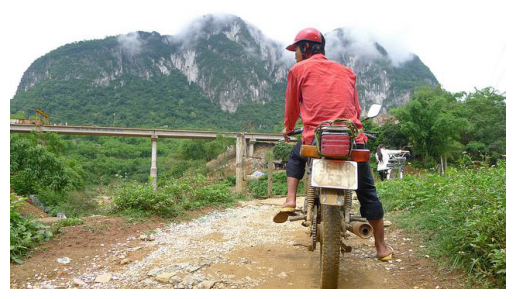

In [7]:
plt.imshow(noisy_image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [8]:
enc_im = model.vision_model.forward(inputs['pixel_values'])
enc_im

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 1.0049,  0.3579, -0.7446,  ...,  0.7065,  0.1138, -0.5010],
         [ 0.6211,  0.2981, -0.8242,  ...,  0.5161, -0.1115, -0.6606],
         [ 0.0639, -1.0312,  0.4150,  ...,  0.5913,  1.2305,  1.5381],
         ...,
         [ 0.9858,  0.6548, -0.8867,  ...,  0.8687, -1.5801, -0.3440],
         [ 1.4736,  0.6348, -1.3340,  ...,  0.7539, -0.6992, -0.9751],
         [ 0.5811, -0.3328,  0.8052,  ...,  0.9209,  1.3076,  1.1465]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 2.1230,  0.7412, -1.7305,  ...,  0.9121,  0.3486, -1.1895]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [9]:
enc_im_array = enc_im.last_hidden_state.cpu().detach().numpy()

# Add random noise to the array
noise = np.random.normal(loc=0, scale=0.7, size=enc_im_array.shape)  # Adjust the scale as needed
noisy_enc_im_array = enc_im_array * 2

# Convert the noisy NumPy array back to a tensor
noisy_enc_im = torch.tensor(noisy_enc_im_array, dtype=torch.float16).to("cuda")
enc_im.last_hidden_state = noisy_enc_im

In [10]:
pixel_values = inputs['pixel_values']
input_ids = None #inputs['input_ids']
attention_mask = None
batch_size = pixel_values.shape[0]
image_embeds = enc_im.last_hidden_state
image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=image_embeds.device)

query_tokens = model.query_tokens.expand(image_embeds.shape[0], -1, -1)
query_outputs = model.qformer(
    query_embeds=query_tokens,
    encoder_hidden_states=image_embeds,
    encoder_attention_mask=image_attention_mask,
    return_dict=True,
)
query_output = query_outputs.last_hidden_state

language_model_inputs = model.language_projection(query_output)
language_attention_mask = torch.ones(
    language_model_inputs.size()[:-1], dtype=torch.long, device=language_model_inputs.device
)
if input_ids is None:
    input_ids = (
        torch.LongTensor([[model.config.text_config.bos_token_id]])
        .repeat(batch_size, 1)
        .to(image_embeds.device)
    )
if attention_mask is None:
    attention_mask = torch.ones_like(input_ids)
attention_mask = torch.cat([language_attention_mask, attention_mask.to(language_attention_mask.device)], dim=1)

# concatenate query embeddings with prompt embeddings
inputs_embeds = model.get_input_embeddings()(input_ids)
inputs_embeds = torch.cat([language_model_inputs, inputs_embeds.to(language_model_inputs.device)], dim=1)

outputs = model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=attention_mask,
)

print(processor.decode(outputs[0], skip_special_tokens=True).strip())

a man riding a motorcycle on a dirt road


In [94]:
outputs

tensor([[    2, 50118]], device='cuda:0')

In [ ]:
pixel_values = inputs['pixel_values']
input_ids = None #inputs['input_ids']
attention_mask = None
batch_size = pixel_values.shape[0]
image_embeds = model.vision_model(pixel_values, return_dict=True).last_hidden_state
image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=image_embeds.device)

query_tokens = model.query_tokens.expand(image_embeds.shape[0], -1, -1)
query_outputs = model.qformer(
    query_embeds=query_tokens,
    encoder_hidden_states=image_embeds,
    encoder_attention_mask=image_attention_mask,
    return_dict=True,
)
query_output = query_outputs.last_hidden_state

language_model_inputs = model.language_projection(query_output)
language_attention_mask = torch.ones(
    language_model_inputs.size()[:-1], dtype=torch.long, device=language_model_inputs.device
)
if input_ids is None:
    input_ids = (
        torch.LongTensor([[model.config.text_config.bos_token_id]])
        .repeat(batch_size, 1)
        .to(image_embeds.device)
    )
if attention_mask is None:
    attention_mask = torch.ones_like(input_ids)
attention_mask = torch.cat([language_attention_mask, attention_mask.to(language_attention_mask.device)], dim=1)

# concatenate query embeddings with prompt embeddings
inputs_embeds = model.get_input_embeddings()(input_ids)
inputs_embeds = torch.cat([language_model_inputs, inputs_embeds.to(language_model_inputs.device)], dim=1)

outputs = model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=attention_mask,
)



In [68]:
print(processor.decode(out[0], skip_special_tokens=True).strip())

a man is standing in front of a building


In [17]:
from models import Clipper
clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:0"), hidden_state=True, norm_embs=True)

clip_seq_dim = 257
clip_emb_dim = 768
hidden_dim = 4096

ViT-L/14 cuda:0


In [19]:
r1 = clip_model.embed_image(torch.randn(1,3,224,224).to('cuda'))

/admin/home-ckadirt/miniconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
clip_model2 = Clipper("ViT-L/14", device=torch.device(f"cuda:0"), hidden_state=False, norm_embs=True)


ViT-L/14 cuda:0


In [20]:
r2 = clip_model2.embed_image(torch.randn(1,3,224,224).to('cuda'))

In [23]:
r2[0,0:10]

tensor([-0.0036,  0.0279,  0.0389,  0.0313,  0.0268, -0.0454,  0.0211, -0.0201,
        -0.0033,  0.0248], device='cuda:0', dtype=torch.float16)

In [26]:
print(r1.shape)

torch.Size([1, 257, 768])


In [25]:
r1[0,-1,0:10]

tensor([-0.0048,  0.0026, -0.0114, -0.0106,  0.0010,  0.0052,  0.0019,  0.0056,
         0.0210, -0.0085], device='cuda:0')